In [1]:
from sklearn import svm
# from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
from nltk.stem import RSLPStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.metrics import classification_report, confusion_matrix

import pandas as pd
import csv
import numpy as np
# Import supplementary visualization code visuals.py
import visuals as vs

import re

In [2]:
!ls

RandomForest.pickle         model.ipynb
__pycache__                 model_plot.png
analysis.Rmd                models
analysis.pdf                out
analysis_files              playlist_processor.py
analysis_final.Rmd          plots
brew                        protest.csv
brz_dictatorship.csv        pt_stopwords.txt
brz_dictatorship_target.csv sequences.txt
danceability.jpeg           speechiness_bp.jpeg
data                        valence_bp.jpeg
energy.jpeg                 visuals.py
influence.py                whosampled_clean_songs.csv
jovem_guarda.csv            whosampled_data.csv
lstm_char_model.ipynb       whosampled_list.csv
main.pyc                    whosampled_scraper.py
model.h5                    wordmodel.ipynb


In [3]:
df = pd.read_csv('brz_dictatorship.csv', encoding='utf-8')
df_test = pd.read_csv('whosampled_data.csv', encoding='utf-8').dropna(axis=0)
df = df.dropna(axis=0)
display(df_test.head())

stopwords = open("pt_stopwords.txt").readlines()
stopwords = list(map(str.strip, stopwords))

df['tempo'] = pd.to_numeric(df['tempo'], downcast="float")
df['duration_ms'] = pd.to_numeric(df['duration_ms'], downcast="float")


,Unnamed: 0,song_sp_uri,song_name,song_isrc,song_popularity,song_lyrics,class,danceability,energy,key,...,valence,tempo,id,duration_ms,time_signature,artist_genres,artist_name,artist_photo,artist_popularity,artist_sp_followers
1,1,spotify:track:4zJnSZJjCmGnkQX1W38ZIl,Calix-Se,US7VG1593526,36,pai sinto falta voce aqui rua campim quanto to...,Protest,0.760,0.744,11,...,0.812,82.004,4zJnSZJjCmGnkQX1W38ZIl,360751,4,brazilian hip hop,Trilha Sonora do Gueto,https://i.scdn.co/image/f44f9e10538aa6391688ca...,45,130298
2,2,spotify:track:744T5MTpQJhem1FPdKvTQ1,Direita Vou Ver,BXRCL1800064,25,"`` continuo sendo socialista , portanto , esqu...",Protest,0.545,0.811,11,...,0.639,79.934,744T5MTpQJhem1FPdKvTQ1,364504,4,adoracao,Mensageiros da Profecia,https://i.scdn.co/image/688287e9b2eefe63a25912...,35,20698
3,3,spotify:track:6Wt61AZLG0bN2KasopE2sj,"Capítulo 4, Versículo 3",US7VG1324929,58,60 % jovens periferia antecedentes criminais j...,Protest,0.625,0.515,8,...,0.903,87.841,6Wt61AZLG0bN2KasopE2sj,486560,4,brazilian hip hop,Racionais MC's,https://i.scdn.co/image/0e9f58b86b301af364cc4c...,67,2495926
4,4,spotify:track:4EBu1H5VUbBRXGtARMnkib,"Brasil Com ""P""",US7VG1539057,21,pesquisa publicada prova : preferencialmente p...,Protest,0.628,0.486,8,...,0.564,57.986,4EBu1H5VUbBRXGtARMnkib,104227,4,brazilian hip hop,GOG,https://i.scdn.co/image/de0d09c17287d9656696bb...,42,47072
5,5,spotify:track:58ZMFOd08nb2WrOoFhI4cY,Filho maravilha,BRWMB9801175,33,"novamente chegou inspiracao amor , emocao , ex...",Protest,0.561,0.865,4,...,0.774,136.564,58ZMFOd08nb2WrOoFhI4cY,215693,4,bossa nova,Jorge Ben Jor,https://i.scdn.co/image/a9c6a324c5f4a0f25bc711...,64,368372


In [4]:
stemmer = RSLPStemmer()
df['cleaned'] = df['song_lyrics'].astype('str')
df['cleaned'] = df['cleaned'].apply(lambda x: " ".join([stemmer.stem(i) for i in re.sub("[^a-zA-Z]", " ", x).split()]).lower())

In [5]:
vectorizer = TfidfVectorizer(min_df= 3, stop_words=stopwords, sublinear_tf=True, norm='l2', ngram_range=(1, 2))
final_features = vectorizer.fit_transform(df['cleaned']).toarray()
final_features.shape

(184, 1391)

In [6]:
from sklearn.base import BaseEstimator, TransformerMixin

class ItemSelector(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key

    def fit(self, df, y=None):
        return self

    def transform(self, df, y=None):
        return df[self.key]

class NumSelector(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key

    def fit(self, df, y=None):
        return self

    def transform(self, df, y=None):
        return df[self.key].values.reshape(-1, 1)


In [7]:
print(df.head(
))

   Unnamed: 0                           song_sp_uri         song_name  \
0           0  spotify:track:0VUgbCK0k8QWGpLiEV8YYZ            Cálice   
1           1  spotify:track:2GAFZG9Z7UGS1iMm4Idrnr    Apesar De Você   
2           2  spotify:track:06ND7qqsmIRCuWdQNQIlTE         Roda-Viva   
3           3  spotify:track:3Ig3k8enaBZy7cohqfnWVz  Como nossos pais   
4           4  spotify:track:3AQg8DR76bH9Ko3mZXuSWK     Mosca Na Sopa   

      song_isrc  song_popularity  \
0  BRPGD7800015               50   
1  BRPGD7800024               57   
2  BRSGL6800006               53   
3  BRWMB9705419               27   
4  BRMCA7300117               45   

                                         song_lyrics    class  danceability  \
0  pai , afasta mim calice pai , afasta mim calic...  Protest         0.596   
1  amanha vai outro dia amanha vai outro dia aman...  Protest         0.568   
2  dias gente sente partiu morreu gente estancou ...  Protest         0.502   
3  nao quero falar grande am

In [8]:
from tabulate import tabulate

from gensim.models.word2vec import Word2Vec
from collections import Counter, defaultdict
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.naive_bayes import BernoulliNB, MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import FeatureUnion
from sklearn.preprocessing import StandardScaler


X = df[['song_lyrics', 'valence', 'duration_ms', 'danceability', 'acousticness', 'tempo']]
y = df['class']

labels = df['class'].map(lambda x : 1 if x == 'Protest' else 0)


# train word to vector on texts 
model = Word2Vec(X['song_lyrics'], size=100, window=5, min_count=5, workers=2)
w2v = {w: vec for w, vec in zip(model.wv.index2word, model.wv.syn0)}


# ('lyrics', Pipeline([
#                 ('selector', ItemSelector(key='song_lyrics')),
#                 ('tfidf', vectorizer),
#             ])),

# multiple machine learning models
mult_nb = Pipeline([('lyrics', Pipeline([
                    ('selector', ItemSelector(key='song_lyrics')),
                    ("count_vectorizer", CountVectorizer(analyzer=lambda x: x)),
                    ])), 
                ("multinomial nb", MultinomialNB())])
bern_nb = Pipeline([('lyrics', Pipeline([
                        ('selector', ItemSelector(key='song_lyrics')),
                        ("count_vectorizer", CountVectorizer(analyzer=lambda x: x)),
                    ])),
                    ("bernoulli nb", BernoulliNB())])

mult_nb_tfidf = Pipeline([('lyrics', Pipeline([
                        ('selector', ItemSelector(key='song_lyrics')),
                        ("tfidf_vectorizer", TfidfVectorizer(analyzer=lambda x: x)),
                    ])), 
                          ("multinomial nb", MultinomialNB())])

bern_nb_tfidf = Pipeline([('lyrics', Pipeline([
                    ('selector', ItemSelector(key='song_lyrics')),
                    ("tfidf_vectorizer", TfidfVectorizer(analyzer=lambda x: x)),
                    ])), ("bernoulli nb", BernoulliNB())])
# SVM 
svc = Pipeline([('lyrics', Pipeline([
                        ('selector', ItemSelector(key='song_lyrics')),
                        ("count_vectorizer", CountVectorizer(analyzer=lambda x: x)),
                ])),
                ("linear svc", SVC(kernel="linear"))])

svc_tfidf = Pipeline([('lyrics', Pipeline([
                    ('selector', ItemSelector(key='song_lyrics')),
                    ("tfidf_vectorizer", TfidfVectorizer(analyzer=lambda x: x)),
                    ])), ("linear svc", SVC(kernel="linear"))])

# Random Forest
random_forest_tfidf = Pipeline([
    ('union', FeatureUnion(
        transformer_list=[

            # Pipeline for pulling features from the post's subject line
            ('lyrics', Pipeline([
                ('selector', ItemSelector(key='song_lyrics')),
                ('tfidf', vectorizer),
            ])),
#             Pipeline for standard bag-of-words model for body
            ('duration', Pipeline([
                ('selector', NumSelector(key='duration_ms')),
                ('minxMax', StandardScaler()),
            ])),
            ('tempo', Pipeline([
                ('selector', NumSelector(key='tempo')),
                ('minxMax', StandardScaler()),
            ])),
        ]
    )),
    # Use a SVC classifier on the combined features
    ('clf', RandomForestClassifier()),
])

random_forest = Pipeline([
    ('union', FeatureUnion(
        transformer_list=[

            # Pipeline for pulling features from the post's subject line
            ('lyrics', Pipeline([
                ('selector', ItemSelector(key='song_lyrics')),
                ("count_vectorizer", CountVectorizer(analyzer=lambda x: x)),
            ])),
            ('duration', Pipeline([
                ('selector', NumSelector(key='duration_ms')),
                ('minxMax', StandardScaler()),
            ])),
            ('tempo', Pipeline([
                ('selector', NumSelector(key='tempo')),
                ('minxMax', StandardScaler()),
            ])),
        ]
    )),
    # Use a SVC classifier on the combined features
    ('clf', RandomForestClassifier()),
])

class MeanEmbeddingVectorizer(object):
    def __init__(self, word2vec):
        self.word2vec = word2vec
        self.dim = len(word2vec.values())
    
    def fit(self, X, y):
        return self 

    def transform(self, X):
        return np.array([
            np.sum([self.word2vec[w] for w in words if w in self.word2vec] 
                    or [np.zeros(self.dim)], axis=0)
            for words in X
        ])
    
# and a tf-idf version of the same
class TfidfEmbeddingVectorizer(object):
    def __init__(self, word2vec):
        self.word2vec = word2vec
        self.word2weight = None
        self.dim = len(word2vec.values())

    def fit(self, X, y):
        tfidf = TfidfVectorizer(analyzer=lambda x: x)
        tfidf.fit(X)
        # if a word was never seen - it must be at least as infrequent
        # as any of the known words - so the default idf is the max of 
        # known idf's
        max_idf = max(tfidf.idf_)
        self.word2weight = defaultdict(
            lambda: max_idf,
            [(w, tfidf.idf_[i]) for w, i in tfidf.vocabulary_.items()])

        return self

    def transform(self, X):
        return np.array([
                np.mean([self.word2vec[w] * self.word2weight[w]
                         for w in words if w in self.word2vec] or
                        [np.zeros(self.dim)], axis=0)
                for words in X
            ])




all_models = [
    ("mult_nb", mult_nb),
    ("mult_nb_tfidf", mult_nb_tfidf),
    ("bern_nb", bern_nb),
    ("bern_nb_tfidf", bern_nb_tfidf),
    ("svc", svc),
    ("svc_tfidf", svc_tfidf),
    ("random_forest", random_forest),
    ("random_forest_tfidf", random_forest_tfidf),
#     ("w2v_tfidf", etree_w2v_tfidf),
]

## Comparing different models
scores = sorted([(name, cross_val_score(model, X, y, cv=5).mean()) 
                 for name, model in all_models])
print(tabulate(scores, floatfmt=".4f", headers=("model", 'score')))

/Users/gabrielsaruhashi/anaconda2/envs/py37/lib/python3.6/site-packages/ipykernel_launcher.py:26: DeprecationWarning: Call to deprecated `syn0` (Attribute will be removed in 4.0.0, use self.wv.vectors instead).
/Users/gabrielsaruhashi/anaconda2/envs/py37/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/gabrielsaruhashi/anaconda2/envs/py37/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/gabrielsaruhashi/anaconda2/envs/py37/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/ga

model                  score
-------------------  -------
bern_nb               0.5862
bern_nb_tfidf         0.5862
mult_nb               0.6362
mult_nb_tfidf         0.5542
random_forest         0.6618
random_forest_tfidf   0.7713
svc                   0.6672
svc_tfidf             0.5652


/Users/gabrielsaruhashi/anaconda2/envs/py37/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


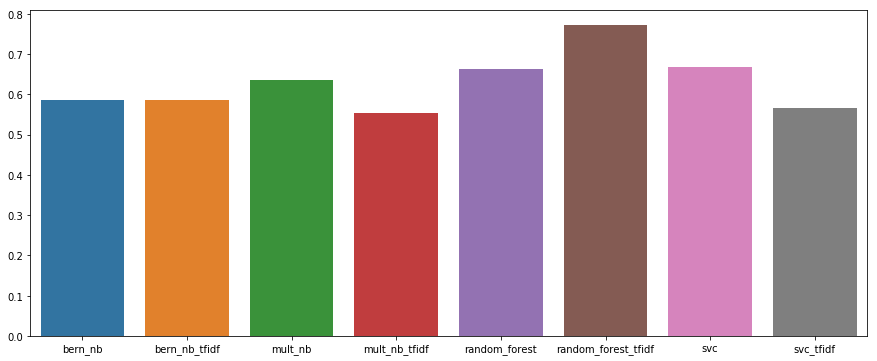

In [9]:
import seaborn as sns

plt.figure(figsize=(15, 6))
sns.barplot(x=[name for name, _ in scores], y=[score for _, score in scores])
plt.savefig('plots/model_performance_bp.png', bbox_inches='tight')


In [10]:
from sklearn.naive_bayes import GaussianNB
from sklearn.decomposition import TruncatedSVD

# this block is to split the dataset into training and testing set 
X = df[['song_lyrics', 'valence', 'duration_ms', 'danceability', 'acousticness', 'tempo']]
Y = df['class']
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.1)

pipeline = Pipeline([
    ('union', FeatureUnion(
        transformer_list=[

            # Pipeline for pulling features from the post's subject line
            ('lyrics', Pipeline([
                ('selector', ItemSelector(key='song_lyrics')),
                ('tfidf', vectorizer),
            ])),
            # Pipeline for standard bag-of-words model for body
            ('duration', Pipeline([
                ('selector', NumSelector(key='duration_ms')),
                ('minxMax', StandardScaler()),
            ])),
            ('tempo', Pipeline([
                ('selector', NumSelector(key='tempo')),
                ('minxMax', StandardScaler()),
            ])),
        ]
    )),
    # Use a SVC classifier on the combined features
    ('clf', RandomForestClassifier()),
])

# fitting our model and save it in a pickle for later use
model = pipeline.fit(X_train, y_train)
# with open('RandomForest.pickle', 'wb') as f:
#     pickle.dump(model, f)

ytest = np.array(y_test)

# confusion matrix and classification report(precision, recall, F1-score)
print(classification_report(ytest, model.predict(X_test)))
print(confusion_matrix(ytest, model.predict(X_test)))

forest = pipeline.steps[1][1]
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the feature importances of the forest
# plt.figure()
# plt.title("Feature importances")
# plt.bar(range(X.shape[1]), importances[indices],
#        color="r", yerr=std[indices], align="center")
# plt.xticks(range(X.shape[1]), indices)
# plt.xlim([-1, X.shape[1]])
# plt.show()

              precision    recall  f1-score   support

Jovem Guarda       0.88      0.58      0.70        12
     Protest       0.55      0.86      0.67         7

   micro avg       0.68      0.68      0.68        19
   macro avg       0.71      0.72      0.68        19
weighted avg       0.75      0.68      0.69        19

[[7 5]
 [1 6]]
Feature ranking:
1. feature 51 (0.065158)
2. feature 1164 (0.056979)
3. feature 1198 (0.029956)
4. feature 646 (0.020509)
5. feature 556 (0.019333)
6. feature 958 (0.018514)


/Users/gabrielsaruhashi/anaconda2/envs/py37/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [11]:
X = df_test[['song_lyrics', 'valence', 'duration_ms', 'danceability', 'acousticness', 'tempo']]
print(len(df_test))
print(df_test[['song_name', 'artist_name', 'artist_photo']])
model.predict(X)

10
                           song_name              artist_name  \
1                           Calix-Se   Trilha Sonora do Gueto   
2                    Direita Vou Ver  Mensageiros da Profecia   
3            Capítulo 4, Versículo 3           Racionais MC's   
4                     Brasil Com "P"                      GOG   
5                    Filho maravilha            Jorge Ben Jor   
6        Flor da Pele / Vapor Barato             Zeca Baleiro   
8                       Rio 40 Graus           Fernanda Abreu   
9                      Monte Castelo            Legião Urbana   
12              Primavera Nos Dentes             Cidade Negra   
13  Senhor delegado / Eu não aguento                    Titãs   

                                         artist_photo  
1   https://i.scdn.co/image/f44f9e10538aa6391688ca...  
2   https://i.scdn.co/image/688287e9b2eefe63a25912...  
3   https://i.scdn.co/image/0e9f58b86b301af364cc4c...  
4   https://i.scdn.co/image/de0d09c17287d9656696bb...  
5

/Users/gabrielsaruhashi/anaconda2/envs/py37/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


array(['Jovem Guarda', 'Protest', 'Protest', 'Protest', 'Jovem Guarda',
       'Protest', 'Protest', 'Protest', 'Protest', 'Protest'],
      dtype=object)

In [12]:
import numpy as np
import os
from gensim.test.utils import datapath
from gensim.models import KeyedVectors

os.environ['KMP_DUPLICATE_LIB_OK']='True'


In [13]:
# Keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Flatten, LSTM, Conv1D, MaxPooling1D, Dropout, Activation
from keras.layers.embeddings import Embedding

target_vocab = list(df['song_lyrics'].str.split(' ', expand=True).stack().unique())
vocabulary_size = len(target_vocab)

tokenizer = Tokenizer(num_words= vocabulary_size)
tokenizer.fit_on_texts(df['song_lyrics'])

sequences = tokenizer.texts_to_sequences(df['song_lyrics'])

maxlen = df['song_lyrics'].str.len().max()
data = pad_sequences(sequences, maxlen=maxlen)


X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.1)



Using TensorFlow backend.


In [14]:
def BinaryClassificationConvModel():
    model_conv = Sequential()
    model_conv.add(Embedding(vocabulary_size, 50, input_length=maxlen, trainable=False))
    model_conv.add(Dropout(0.2))
    model_conv.add(Conv1D(64, 5, activation='relu'))
    model_conv.add(MaxPooling1D(pool_size=4))
    model_conv.add(LSTM(50))
    model_conv.add(Dense(1, activation='sigmoid'))
    model_conv.compile(loss='binary_crossentropy', optimizer='adam',    metrics=['accuracy'])
    return model_conv

model_conv = BinaryClassificationConvModel()
model_conv.fit(X_train, np.array(y_train), epochs = 50,  validation_data=(X_test, y_test))

Train on 165 samples, validate on 19 samples
Epoch 1/50
165/165 [==============================] - 10s 59ms/step - loss: 0.6907 - acc: 0.5576 - val_loss: 0.7023 - val_acc: 0.3684
Epoch 2/50
165/165 [==============================] - 6s 38ms/step - loss: 0.6871 - acc: 0.5515 - val_loss: 0.7035 - val_acc: 0.3684
Epoch 3/50
165/165 [==============================] - 7s 40ms/step - loss: 0.6850 - acc: 0.5515 - val_loss: 0.7099 - val_acc: 0.3684
Epoch 4/50
165/165 [==============================] - 6s 35ms/step - loss: 0.6806 - acc: 0.5515 - val_loss: 0.7151 - val_acc: 0.3684
Epoch 5/50
165/165 [==============================] - 6s 38ms/step - loss: 0.6772 - acc: 0.5515 - val_loss: 0.7194 - val_acc: 0.3684
Epoch 6/50
165/165 [==============================] - 6s 36ms/step - loss: 0.6740 - acc: 0.5515 - val_loss: 0.7148 - val_acc: 0.3684
Epoch 7/50
165/165 [==============================] - 6s 37ms/step - loss: 0.6691 - acc: 0.5515 - val_loss: 0.7201 - val_acc: 0.3684
Epoch 8/50
165/165 [===